In [ ]:
# TODO:
# move generic func out to generic repo
# implement conversion of pred_y back to annots

In [21]:
import pandas as pd
import numpy as np
import pathlib
import cv2
from sklearn.preprocessing import Binarizer
import matplotlib.pyplot as plt
from typing import List, Tuple
from hydra import initialize, compose
from omegaconf import OmegaConf


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, SpatialDropout2D, Concatenate, LeakyReLU, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import Callback

%matplotlib inline
initialize("./configs")


ValueError: GlobalHydra is already initialized, call GlobalHydra.instance().clear() if you want to re-initialize

In [2]:
cfg = compose(config_name="config.yaml")
np.random.seed(cfg.project_setup.RANDOM_STATE_N)

PATH_TRAIN_IMAGE_FOLDER = pathlib.Path(cfg.project_setup.paths.data.TRAIN_IMAGE_FOLDER)
PATH_TRAIN_METADATA = pathlib.Path(cfg.project_setup.paths.data.TRAIN_METADATA)

print(OmegaConf.to_yaml(cfg))

project_setup:
  paths:
    data:
      TRAIN_IMAGE_FOLDER: ./data/train
      TRAIN_METADATA: ./data/train.csv
  RANDOM_STATE_N: 19
  tensorboard:
    SERVER_PORT: 6006
    LOG_DIR: logs
preprocessing:
  INPUT_SHAPE:
    HEIGHT: 520
    WIDTH: 704
  OUTPUT_SHAPE:
    HEIGHT: 512
    WIDTH: 704
  TRANS_POWER: 2
training:
  device:
    GPU: 1
  model:
    LEARNING_RATE: 1.0e-07
    VAL_SIZE: 0.1
    BATCH_SIZE: 4
    EPOCHS: 50
    PATIENCE: 6



In [22]:
# funcs
def get_items_on_path(path: pathlib.Path) -> List[pathlib.Path]:
    """
    Function to combine directory path with individual items on path
    """

    items_on_path = []
    for filepath in path.iterdir():
        items_on_path.append(filepath)
    return items_on_path

def get_image_and_reshape(path_single_image: pathlib, image_shape: Tuple[int, int], image_format:str="png") -> Tuple[np.ndarray, str]:
    """Function to load image and reshape to desired shape"""
    
    image_id = path_single_image.name.replace(f".{image_format}", "")
    image=cv2.imread(str(path_single_image), cv2.IMREAD_GRAYSCALE) #cv2 imread takes only str
    return image.reshape(*image_shape, 1), image_id


# def plot_multiple_img(images: List[np.ndarray], rows: int, cols: int) -> None:
#     """
#     Display images from dataset.
#     """
    
#     _, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(16,8))
#     for ind, image in enumerate(images):        
#         ax.ravel()[ind].imshow(image)
#         ax.ravel()[ind].set_axis_off()
#     plt.tight_layout()
#     plt.show()

def rle_decode(mask_rle: str,  shape: Tuple[int, int, int], color: int = 1) -> np.ndarray:
    """
    Run-Length decoding.

    mask_rle: run-length as string formated (start length)
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    """ 

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths

    img = np.zeros((shape[0] * shape[1], shape[2]), dtype = np.float32)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = color
    return img.reshape(shape)

def grayscale_mask(annots: str, shape: Tuple[int, int, int]) -> np.ndarray:
    """ Create grayscale mask from rle-mask(s). run-length-mask are encoded as string (start length)"""

    grayscale_mask = np.zeros((shape[0], shape[1], shape[2]))
    
    for annot in annots:
            grayscale_mask += rle_decode(annot, shape)
    
    return grayscale_mask.clip(0, 1)

# def rgb_mask(annots: str, shape: Tuple[int, int, int]) -> np.ndarray:
#     """ Create RGB mask from rle-mask(s). run-length-mask are encoded as string (start length)"""

#     rgb_mask = np.zeros((shape[0], shape[1], shape[2]))
    
#     for annot in annots:
#         rgb_mask += rle_decode(mask_rle=annot, shape=shape, color=np.random.rand(3))
    
#     return rgb_mask.clip(0, 1)

# def plot_image_with_annot(image: np.ndarray, rle_masks: str, img_2d_shape: Tuple[int, int], normalize_hist:bool=True) -> None:
#     """Plot image with rle-mask in greyscale and in rbg"""

#     grayscale_masks=grayscale_mask(rle_masks, shape=(*img_2d_shape, 1))
#     rgb_masks=rgb_mask(rle_masks, shape=(*img_2d_shape, 3))

#     plt.figure(figsize = (20 , 4))
#     plt.subplot(1, 4, 1)
#     plt.imshow(image, cmap = "gray")
#     plt.title("Original Image", fontsize = 16)
#     plt.axis("off")

#     plt.subplot(1, 4, 2)
#     plt.imshow(image * grayscale_masks, cmap = "gray")
#     plt.title('Input image with mask', fontsize = 16)
#     plt.axis("off")

#     plt.subplot(1, 4, 3)
#     plt.imshow(rgb_masks)
#     plt.title('RGB mask', fontsize = 16)
#     plt.axis("off")
    
#     plt.subplot(1, 4, 4)
#     if normalize_hist:
#         plt.hist(image.flatten() / 255, bins = 255, range = (0, 1))
#     else:
#         plt.hist(image.flatten(), bins=255, range=(0, 1))
#     plt.title('Pixel distribution', fontsize = 16)
    
#     plt.suptitle("For a sample image, masks and their pixel distributions", fontsize = 20)
#     plt.tight_layout(rect = [0, 0, 0.90, 1])
#     plt.show()


def transform_image_contrast(img_data: np.ndarray, power:int = 2) -> np.ndarray:
    img_data_mask = np.ones_like(img_data, dtype = np.int16)
    img_data_mask[img_data < 127.5] = -1
    
    img_data_transformed = img_data.astype(np.int16) - 127.5
    img_data_transformed[img_data_transformed > 0] = np.power(img_data_transformed[img_data_transformed > 0], 1 / power)
    img_data_transformed[img_data_transformed < 0] = np.power(-img_data_transformed[img_data_transformed < 0], 1 / power)
    img_data_transformed = ((img_data_transformed * img_data_mask) / (2 * np.power(127.5, 1 / power))) + 0.5
    
    return img_data_transformed


def unet_model(input_img_shape: Tuple[int,int,int]):
    input_layer = Input(shape = input_img_shape, name = 'Input_Layer')
    
    conv_1 = Conv2D(16, 5, padding = 'same', activation = LeakyReLU(), name = 'Conv_1')(input_layer)
    pool_1 = MaxPool2D(name = 'Max_Pool_1')(conv_1)
    spd_1 = SpatialDropout2D(0.1, name = 'SPD_1')(pool_1)
    
    conv_2 = Conv2D(32, 4, padding = 'same', activation = LeakyReLU(), name = 'Conv_2')(spd_1)
    pool_2 = MaxPool2D(name = 'Max_Pool_2')(conv_2)  
    conv_3 = Conv2D(64, 4, padding = 'same', activation = LeakyReLU(), name = 'Conv_3')(pool_2)
    pool_3 = MaxPool2D(name = 'Max_Pool_3')(conv_3)
    spd_2 = SpatialDropout2D(0.1, name = 'SPD_2')(pool_3)
    
    conv_4 = Conv2D(128, 3, padding = 'same', activation = LeakyReLU(), name = 'Conv_4')(spd_2)
    pool_4 = MaxPool2D(name = 'Max_Pool_4')(conv_4)
    conv_5 = Conv2D(256, 3, padding = 'same', activation = LeakyReLU(), name = 'Conv_5')(pool_4)
    pool_5 = MaxPool2D(name = 'Max_Pool_5')(conv_5)
    spd_3 = SpatialDropout2D(0.1, name = 'SPD_3')(pool_5)
    
    conv_6 = Conv2D(512, 2, padding = 'same', activation = LeakyReLU(), name = 'Conv_6')(spd_3)
    pool_6 = MaxPool2D(name = 'Max_Pool_6')(conv_6)
    
    conv_t_1 = Conv2DTranspose(256, 1, padding = 'same', strides = 2, activation = LeakyReLU(), name = 'Conv_T_1')(pool_6)
    concat_1 = Concatenate(name = 'Concat_1')([conv_t_1, spd_3])
    spd_4 = SpatialDropout2D(0.1, name = 'SPD_4')(concat_1)
    
    conv_t_2 = Conv2DTranspose(128, 3, padding = 'same', strides = 2, activation = LeakyReLU(), name = 'Conv_T_2')(spd_4)
    conv_t_3 = Conv2DTranspose(64, 3, padding = 'same', strides = 2, activation = LeakyReLU(), name = 'Conv_T_3')(conv_t_2)
    concat_2 = Concatenate(name = 'Concat_2')([conv_t_3, spd_2])
    spd_5 = SpatialDropout2D(0.1, name = 'SPD_5')(concat_2)
    
    conv_t_4 = Conv2DTranspose(32, 4, padding = 'same', strides = 2, activation = LeakyReLU(), name = 'Conv_T_4')(spd_5)
    conv_t_5 = Conv2DTranspose(16, 4, padding = 'same', strides = 2, activation = LeakyReLU(), name = 'Conv_T_5')(conv_t_4)
    concat_3 = Concatenate(name = 'Concat_3')([conv_t_5, spd_1])
    spd_6 = SpatialDropout2D(0.1, name = 'SPD_6')(concat_3)
    
    conv_t_6 = Conv2DTranspose(8, 5, padding = 'same', strides = 2, activation = LeakyReLU(), name = 'Conv_T_6')(spd_6)
    
    output_layer = Conv2DTranspose(1, 5, padding = 'same', activation = 'sigmoid', name = 'Output_Layer')(conv_t_6)
    
    return Model(inputs = input_layer, outputs = output_layer, name = 'Sartorius')

class LRFinder(Callback):
    """Callback that exponentially adjusts the learning rate after each training batch between start_lr and
    end_lr for a maximum number of batches: max_step. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the plot method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.weights = self.model.get_weights()
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.weights)

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [10]:
# read meta data
train_metadata = pd.read_csv(PATH_TRAIN_METADATA)

## load all train images into memory as dictionary with image_id as key and the image (np.ndarray) as value
input_img_shape = (cfg.preprocessing.INPUT_SHAPE.HEIGHT, cfg.preprocessing.INPUT_SHAPE.WIDTH)

train_images_paths = get_items_on_path(PATH_TRAIN_IMAGE_FOLDER)
train_images = [get_image_and_reshape(train_image_path, input_img_shape) for train_image_path in train_images_paths]
train_images_dict = {image_id: image for image, image_id in train_images}

Data Preparation
Loading and Transforming the images into their corresponding grayscale masks

In [17]:
image_ids=list(train_images_dict.keys())
np.random.shuffle(image_ids)

X = []
y = []

for imd_id in image_ids:
    # prepare x
    image = train_images_dict[imd_id]
    prepared_x_2d = cv2.resize(
        transform_image_contrast(image, cfg.preprocessing.TRANS_POWER), 
        (cfg.preprocessing.OUTPUT_SHAPE.WIDTH, cfg.preprocessing.OUTPUT_SHAPE.HEIGHT)
    )
    prepared_x_3d = prepared_x_2d.reshape(
        cfg.preprocessing.OUTPUT_SHAPE.HEIGHT, cfg.preprocessing.OUTPUT_SHAPE.WIDTH, 1
    )
    X.append(prepared_x_3d)

    # prepare y
    annots=train_metadata[train_metadata["id"] == imd_id]["annotation"].tolist()
    prepared_y_2d = cv2.resize(
        grayscale_mask(
            annots,
            (cfg.preprocessing.INPUT_SHAPE.HEIGHT, cfg.preprocessing.INPUT_SHAPE.WIDTH, 1)
        ),
        (cfg.preprocessing.OUTPUT_SHAPE.WIDTH, cfg.preprocessing.OUTPUT_SHAPE.HEIGHT)
    )
    prepared_y_3d = prepared_y_2d.reshape(
        cfg.preprocessing.OUTPUT_SHAPE.HEIGHT, cfg.preprocessing.OUTPUT_SHAPE.WIDTH, 1
    )
    y.append(prepared_y_3d)

X = np.array(X)
y = np.array(y)
y = Binarizer().transform(y.reshape(-1, 1)).reshape(y.shape) # make y (segmentation labels) binary


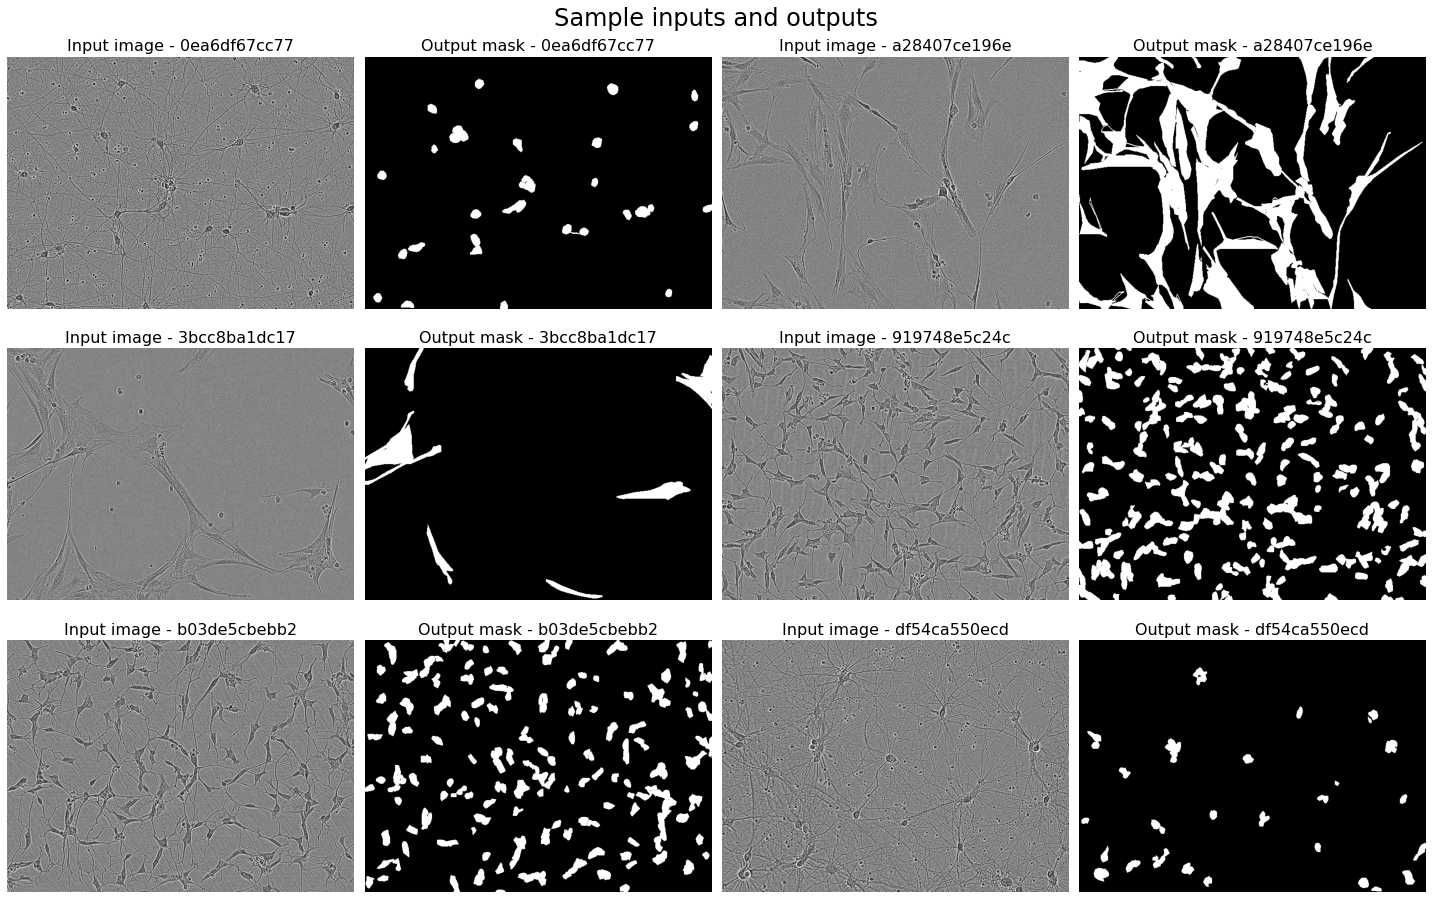

In [18]:
plt.figure(figsize = (20 , 13))

for idx_cnt, idx_rnd_image in enumerate(np.random.randint(len(image_ids), size = 6)):
    plt.subplot(3, 4, (idx_cnt * 2) + 1)
    plt.imshow(X[idx_rnd_image], cmap = 'gray')
    plt.title(f'Input image - {image_ids[idx_rnd_image]}', fontsize = 16)
    plt.axis("off")
    
    plt.subplot(3, 4, (idx_cnt * 2) + 2)
    plt.imshow(y[idx_rnd_image], cmap = 'gray')
    plt.title(f'Output mask - {image_ids[idx_rnd_image]}', fontsize = 16)
    plt.axis("off")
    
plt.suptitle("Sample inputs and outputs", fontsize = 24)
plt.tight_layout()
plt.show()

In [20]:
model=unet_model((cfg.preprocessing.OUTPUT_SHAPE.HEIGHT, cfg.preprocessing.OUTPUT_SHAPE.WIDTH, 1))
model.compile(optimizer = Adam(cfg.training.model.LEARNING_RATE), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "Sartorius"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 512, 704, 1) 0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 512, 704, 16) 416         Input_Layer[0][0]                
__________________________________________________________________________________________________
Max_Pool_1 (MaxPooling2D)       (None, 256, 352, 16) 0           Conv_1[0][0]                     
__________________________________________________________________________________________________
SPD_1 (SpatialDropout2D)        (None, 256, 352, 16) 0           Max_Pool_1[0][0]                 
__________________________________________________________________________________________

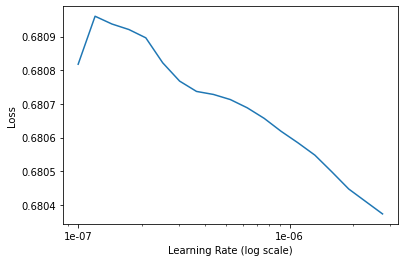

In [23]:
lr_finder = LRFinder()
with tf.device(f'/device:GPU:{cfg.training.device.GPU}'):
    _ = model.fit(X, y, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [25]:
# %load_ext tensorboard
# %tensorboard --logdir logs --bind_all

def train(cfg: OmegaConf, X: np.ndarray, y: np.ndarray) -> None:
    """ Main trainings loop execution"""
    
    tf.debugging.set_log_device_placement(True)
    tf.profiler.experimental.server.start(cfg.project_setup.tensorboard.SERVER_PORT)
    
    tb_callback = tf.keras.callbacks.TensorBoard(
        log_dir=cfg.project_setup.tensorboard.LOG_DIR,
        histogram_freq=0,
        write_graph=True,
        write_images=False,
        write_steps_per_second=False,
        update_freq='epoch',
        profile_batch=(10,20),
        embeddings_freq=0,
        embeddings_metadata=None,
    )

    early_stop = EarlyStopping(monitor = 'val_loss', patience = cfg.training.model.PATIENCE, restore_best_weights = True)
    with tf.device(f'/device:GPU:{cfg.training.device.GPU}'):
        history = model.fit(
            X, y,
            batch_size = cfg.training.model.BATCH_SIZE,
            epochs = cfg.training.model.EPOCHS,
            validation_split = cfg.training.model.VAL_SIZE,
            callbacks = [early_stop, tb_callback]
        )

In [26]:
%time
train(cfg, X, y)

CPU times: user 8 µs, sys: 3 µs, total: 11 µs
Wall time: 22.6 µs
Epoch 1/50
 55/137 [===========>..................] - ETA: 3s - loss: 0.6788 - accuracy: 0.6911

KeyboardInterrupt: 

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs_range = history.epoch

plt.figure(figsize = (18, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right', fontsize = 14)
plt.ylim(0, 1)
plt.title('Loss', fontsize = 20)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right', fontsize = 14)
plt.title('Accuracy', fontsize = 20)

plt.suptitle("Evaluation Metrics", fontsize = 24)
plt.savefig('loss_and_accuracy.jpg', dpi = 150, bbox_inches = 'tight')
plt.show()

NameError: name 'history' is not defined

# Predicting masks

In [ ]:
## Finding optimal threshold for creating a binary mask
preds = model.predict(X)
threshold_ranges = np.arange(0.25, 0.76, 0.05)

accuracies = []

for threshold in threshold_ranges:
    pred_mask = Binarizer(threshold = threshold).transform(preds.reshape(-1, 1)).reshape(preds.shape)
    accuracies.append((pred_mask == y).sum() / pred_mask.size)

threshold_results_df = pd.DataFrame({
    'threshold': threshold_ranges,
    'accuracy': accuracies
}).round(3).sort_values('accuracy', ascending = False)

threshold_results_df

In [ ]:
# Visualizing Predictions with optimal threshold for creating binary mask
num_preds = 5
sample_pred_ids = np.random.randint(len(X), size = num_preds)

pred_y = model.predict(X[sample_pred_ids])
pred_y_mask = Binarizer(threshold = threshold_results_df['threshold'].iloc[0]).transform(pred_y.reshape(-1, 1)).reshape(pred_y.shape)

plt.figure(figsize = (20 , 20))
for i in range(num_preds):
    plt.subplot(num_preds, 4, (4 * i) + 1)
    plt.imshow(X[sample_pred_ids[i]], cmap = 'gray')
    plt.axis('off')
    plt.title(f'Input image - {image_ids[sample_pred_ids[i]]}', fontsize = 16)
    
    plt.subplot(num_preds, 4, (4 * i) + 2)
    plt.imshow(y[sample_pred_ids[i]], cmap = 'gray')
    plt.axis('off')
    plt.title('Expected output mask', fontsize = 16)
    
    plt.subplot(num_preds, 4, (4 * i) + 3)
    plt.imshow(pred_y[i], cmap = 'gray')
    plt.axis('off')
    plt.title('Predicted mask', fontsize = 16)
    
    plt.subplot(num_preds, 4, (4 * i) + 4)
    plt.imshow(pred_mask[i], cmap = 'gray')
    plt.axis('off')
    plt.title('Binarized mask', fontsize = 16)
    
plt.suptitle("Sample inputs and outputs", fontsize = 24)
plt.tight_layout(rect = [0, 0, 0.90, 1])
plt.show()

Convert pred_y into individual cells and encode back using RLE